In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Preparation

Import the MNIST dataset with tensorflow, to have it as numpy arrays.

- **x_train** = (60000, 28, 28)
- **y_train** = (60000,)
- **x_test**  = (10000, 28, 28)
- **y_test**  = (10000,)

In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Convert the numpy arrays to tensors. The arrays containing the 28x28 images are flattened using `view()`, which preserves the shape at the first dimension and infers the other one. This leads to 2d tensors with size 784 in the second dimension. The values are also cast using `float()`, to prevent an error when feeding them into the linear layers.

In [3]:
x_train = torch.tensor(x_train).view(x_train.shape[0], -1).float()
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test).view(x_test.shape[0], -1).float()
y_test = torch.tensor(y_test)

## Define the Model

The module has two hidden layers. The first linear layer has 128 neurons and the `relu` non-linearity is applied to its outputs. The second linear layer simply takes the outputs of the first and gives us the 10 results. Note that I don't apply a softmax after that layer. Pytorch's `nn.CrossEntropyLoss` normalizes data on its own.

In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.l1 = nn.Linear(in_features=784, out_features=128, bias=False)
        self.l2 = nn.Linear(in_features=128, out_features=10, bias=False)
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.l2(out)
        return out

Here we define our *loss function*, *optimizer* and *batch size*. I stuck to the most common ones used for MNIST like classification problems.

In [5]:
model = NN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
BS = 128
losses, accuracies = [], []

## Training

I first set the model into training mode. I then iterate 1000 times. In every iteration a random sample from the dataset is drawn, fed through the neural net and the loss and accuracy of the current batch are calculated. I don't use a dataloader and I don't really worry about some images probably being sampled a lot while others might not even be sampled once during the whole training process.

In [6]:
model.train()
for i in range(1000):
    idx = torch.randint(low=0, high=x_train.shape[0], size=(BS,))
    xs = x_train[idx]
    ys = y_train[idx]
    out = model(xs)
    pred = torch.argmax(out, dim=1)
    accuracy = (ys == pred).float().mean()
    model.zero_grad()
    loss = loss_function(out, ys)
    loss.backward()
    optimizer.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    if i % 100 == 0: print("step %3d: loss %.2f, accuracy %.2f" % (i, loss, accuracy))

step   0: loss 25.94, accuracy 0.14
step 100: loss 0.39, accuracy 0.85
step 200: loss 0.32, accuracy 0.89
step 300: loss 0.37, accuracy 0.89
step 400: loss 0.49, accuracy 0.90
step 500: loss 0.43, accuracy 0.88
step 600: loss 0.45, accuracy 0.91
step 700: loss 0.25, accuracy 0.93
step 800: loss 0.08, accuracy 0.98
step 900: loss 0.09, accuracy 0.95


## Results

Check if the losses and accuracies look good. The initial loss is pretty horrible and way worse than it should be. Maybe I'll tweak that in the future.

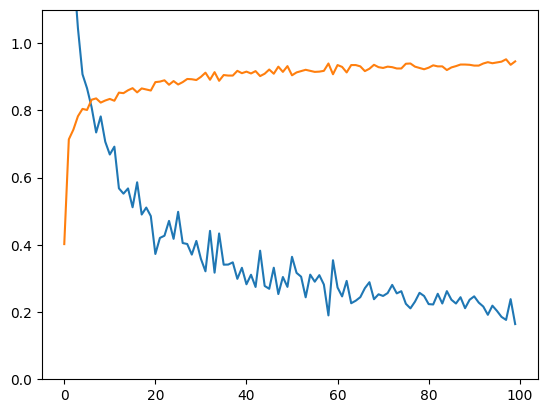

In [7]:
plt.ylim(0, 1.1)
plt.plot(torch.tensor(losses).view(100, -1).mean(axis=1))
plt.plot(torch.tensor(accuracies).view(100, -1).mean(axis=1))

See how the model performs on the test data.

In [8]:
model.eval()
with torch.no_grad():
    xs = torch.Tensor(x_test).float()
    ys = torch.Tensor(y_test).long()
    out = model(xs)
    pred = torch.argmax(out, dim=1)
    accuracy = (ys == pred).float().mean()
print("test accuracy: %.2f" % (accuracy.item()))

test accuracy: 0.93


Check if the gradients have nice values. We don't like dead gradients.

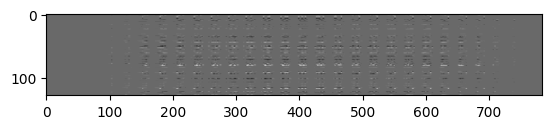

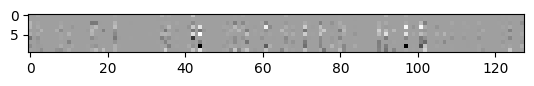

In [9]:
plt.imshow(model.l1.weight.grad, cmap="gray")
plt.figure()
plt.imshow(model.l2.weight.grad, cmap="gray")